In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import fastscapelib_fortran as fs
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Parapatric Speciation Model

**Store initial population data**
* population info stored as dataframes with columns:
    * gen: generation number
    * x: x location
    * y: y location
    * u: trait value
    * a_id: parent id (index value in df)
    * n_neighbors: number of individuals in window (window size defined later)
    * r_d: carrying capacity / n_neighbors
    * u_opt: optimal trait value (environmental value at x, y)
    * w_i: environmental fitness based on u and u_opt
    * n_offspring: number of offspring individual produces (r_d * w_i)

In [22]:
def initialize_population(pop_size, gen, x, y, u, a_id):
    columns = ['gen', 'x', 'y', 'u', 'a_id', 'n_neighbor', 'r_d', 'u_opt', 'w_i', 'n_offspring']
    population = pd.DataFrame(columns=columns, index=np.arange(0, pop_size))
    population.loc[:, ['gen', 'x', 'y', 'u', 'a_id']] = list(zip(gen, x, y, u, a_id))
    
    return population

In [23]:
def generation(gen, pop, env, dt, lifespan, capacity, window, sigma_w, sigma_d, sigma_mut, m_freq):
    """
    gen: generation number 
    pop: dataframe with population information, columns = columns in initialize population
    env: 2D array of environmental parameter the population is adapting to (e.g. elevation, precipitation)
    dt: time step
    lifespan: reproductive lifespan of population
    capacity: capacity of landscape in given area (window)
    window: window size to evaluate capacity (given in n grid cells, not area)
    sigma_w: width of gaussian fitness curve
    sigma_d: width of dispersal curve, occurs for every individual at each timestep
    sigma_mut: width of mutation curve, occurs for every individual at each timestep, dependent on dgen and m_freq
    m_freq: mutation probability for an individual in a given generation
    
    """

    dgen = dt/lifespan  # number of generations to iterate through for a given dt
    
    # scale paramters to time (dgen)
    sigma_w*=np.sqrt(dgen)
    sigma_d*=np.sqrt(dgen)
    sigma_mut*=(np.sqrt(dgen)*np.sqrt(m_freq))
    
    # shape of landscape
    nx = env.shape[1]
    ny = env.shape[0]
    
    # find population gen
    p = pop[pop.gen==gen].copy()
    
    # get ids for population at gen
    p_id = p.index

    col_update = ['n_neighbor', 'r_d', 'u_opt', 'w_i', 'n_offspring']
    
    
    #### Assess fitness and n_offspring for population_gen ####
    
    # find number of neighbors in window
    n_neighbor = []
    for i, row in p.iterrows():
        xi = row.x
        yi = row.y
        w = window/2
        
        xmin, xmax, ymin, ymax = xi-w, xi+w, yi-w, yi+w
        
        
        n = p[(p.x>xmin) & (p.x<xmax) & (p.y>ymin) & (p.y<ymax)].shape[0]
        n_neighbor.append(n)
    
    p['n_neighbor'] = n_neighbor

    # calcuate r_d
    p['r_d'] = capacity / p.n_neighbor
    
    # find u_opt for individuals
    p['u_opt'] = env[p.y.astype(int), p.x.astype(int)]

    # calculate fitness
    i_wi = -(p.u-p.u_opt)**2/(2*sigma_w**2)
    p['w_i'] = i_wi.apply(lambda x: np.exp(x))

    # calcluate number of offspring per individual (r_d * fitness)
    p['n_offspring'] = round(p.r_d * p.w_i)
    
    # update columns of population df
    pop.loc[p_id, col_update] = p.loc[p_id, col_update]

    
    #### produce offspring (generation = gen+1) ####
    
    # number of offspring in new generation
    n_newgen = p.n_offspring.sum()
    
    # create new generation id (column gen)
    gen_id = np.ones(int(n_newgen)) * (gen+1)
    
    # create list of ancester ids for new offspring
    ancestors = p[p.n_offspring>0]  # find individuals with offspring
    
    # generate array of ancestral ids for each new individual (column a_id)
    a_id = []
    for i, row in ancestors.iterrows():
        a = np.ones(int(row.n_offspring))*i  # generate array of repeating id that is n_offspring long
        a_id.extend(a)
    
    # mutate new offspring
    u_mut = p.loc[a_id, 'u'].copy()
    u_mut = np.random.normal(u_mut, sigma_mut)
    
    # inherited location of offspring
    p_loc = p.loc[a_id, ['x', 'y']].copy()
    
    # add 'dispersal' to p_loc
    # select new location from normal distribution (using parent loc and sigma_d)
    # need to stay within the bounds of the model
    x_new = []
    for x in p_loc.x:
        new = stats.truncnorm.rvs((0-x) / sigma_d, 
                                ((nx-1) - x) / sigma_d,
                                loc=x, scale=sigma_d, size=1)
        x_new.append(new[0])
    
    y_new = []
    for y in p_loc.y:
        new = stats.truncnorm.rvs((0-y) / sigma_d,
                                 ((ny-1) - y) / sigma_d,
                                 loc=y, scale=sigma_d, size=1)
        
        y_new.append(new[0])
    
     
    columns = ['gen', 'x', 'y', 'u', 'a_id']
    
    # if new offspring are created, add them to population df
    if n_newgen>0:
        add = initialize_population(n_newgen, gen_id, x_new, y_new, u_mut, a_id)
        pop = pop.append(add, ignore_index=True)
        
    return pop

In [ ]:
def run_model(pop_size, capacity):
    gen = np.zeros(pop_size)
    sx = np.random.randint(0, nx, pop_size)
    sy = np.random.randint(0, ny, pop_size)
    u = np.random.randint(0, h.max(), pop_size)
    ancestor = np.ones(pop_size) * -1
    
    pop_params = {
    'dt':dt,
    'lifespan':lifespan,
    'window':window,
    'capacity':capacity,
    'sigma_w':50,
    'sigma_d':.5,
    'm_freq':0.05 ,
    'sigma_mut': 2500/ny * .5  
    }
    
    population = initialize_population(pop_size, gen, sx, sy, u, ancestor)

    for g in range(50):
        population = generation(g, population, h, **pop_params)

In [24]:
def record_hist(array, history):
    new = array.reshape(ny, nx)
    history = np.dstack((history, new))
    return(history)

# Run in static landscape

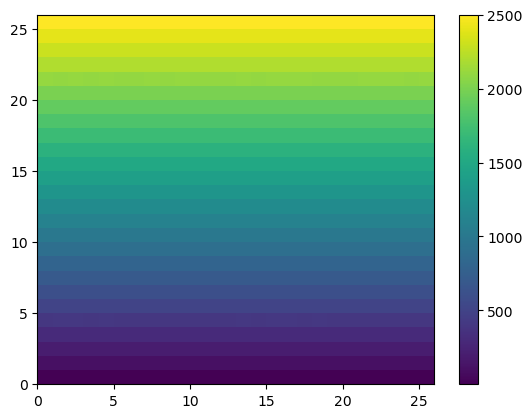

In [25]:
nx = 26
ny = 26
nn = nx*ny

xl = nx-1
yl = ny-1

xlist = np.linspace(0, xl, nx)
ylist = np.linspace(0, yl, ny)
X, Y = np.meshgrid(xlist, ylist)

h = Y*100 + np.random.random_sample((nx, ny)) 
plt.pcolormesh(h)
plt.colorbar()

In [26]:
pop_size = 100
gen = np.zeros(pop_size)
sx = np.random.randint(0, nx, pop_size)
sy = np.random.randint(0, ny, pop_size)
u = np.random.randint(0, h.max(), pop_size)
ancestor = np.ones(pop_size) * -1

dt = 5
lifespan = 1
window = 5


population = initialize_population(pop_size, gen, sx, sy, u, ancestor)

pop_params = {
    'dt':dt,
    'lifespan':lifespan,
    'window':window,
    'capacity':10,
    'sigma_w':50,
    'sigma_d':.5,
    'm_freq':0.05 ,
    'sigma_mut': 2500/ny * .5  

}

In [27]:
population = population.reset_index()

population.head()

,index,gen,x,y,u,a_id,n_neighbor,r_d,u_opt,w_i,n_offspring
0,0,0.0,0,23,537,-1.0,NaN,NaN,NaN,NaN,NaN
1,1,0.0,20,8,550,-1.0,NaN,NaN,NaN,NaN,NaN
2,2,0.0,11,17,2270,-1.0,NaN,NaN,NaN,NaN,NaN
3,3,0.0,0,14,755,-1.0,NaN,NaN,NaN,NaN,NaN
4,4,0.0,20,20,2327,-1.0,NaN,NaN,NaN,NaN,NaN


In [28]:
step = 50
for g in range(step):
    population = generation(g, population, h, **pop_params)
    if g%10==0:
        print('step %d, pop size = %d' %(g, population[population.gen==g].shape[0]))

step 0, pop size = 100
step 10, pop size = 121
step 20, pop size = 157
step 30, pop size = 184
step 40, pop size = 163


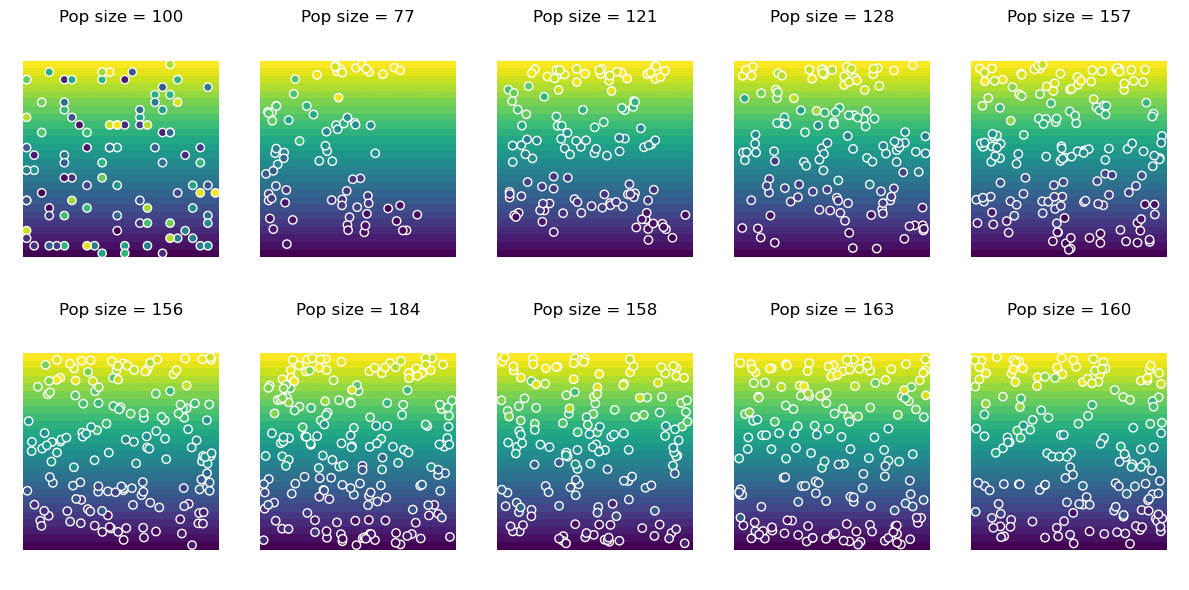

In [29]:
gens = population.gen.unique()
plot_steps = np.arange(0, step, 5)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axs = axs.ravel()

for i, g in enumerate(plot_steps):
    pop = population[population.gen==g]
    axs[i].pcolormesh(h.reshape(ny, nx))
    axs[i].scatter(pop.x+0.5, pop.y+0.5, c=pop.u, edgecolor='w')
    axs[i].axis('equal')
    axs[i].set_title('Pop size = %d' % pop.shape[0])
    axs[i].set_xlim(0,26)
    axs[i].set_ylim(0,26)
    axs[i].axis('off')

fig.tight_layout()


In [11]:
%timeit run_model(100, 10)

3.7 s ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Run with FastScape

In [32]:
# initial topography
nx = 51
ny = 51
nn = nx*ny

xl = 10.e3
yl = 10.e3

xlist = np.linspace(0, xl, nx)
ylist = np.linspace(0, yl, ny)
X, Y = np.meshgrid(xlist, ylist)
x = X.reshape(nn)
y = Y.reshape(nn)

h = np.ones((ny,nx))*100 + np.random.random_sample((ny, nx))
h = h.reshape(nn)
h = np.where((x>xl-1) | (y<1) | (y>yl-1) | (x<1), 0, h)

# FastScape parameters 
dt = 1e3

kf = np.ones(nn) * 1.e-4
kfsed = 1.e-4
kd = np.ones(nn) * 1.e-2
kdsed = 1.e-2
m = 0.4
n = 1. 
g1 = 1.0
g2 = 1.0
expp = 1.0

# initialize fastscape
fs.fastscape_init()

fs.fastscape_set_nx_ny(nx, ny)

fs.fastscape_setup()

fs.fastscape_set_xl_yl(xl, yl)

fs.fastscape_set_dt(dt)

fs.fastscape_set_erosional_parameters(kf, kfsed, m, n, kd, kdsed, g1, g2, expp)

bc = 1111
fs.fastscape_set_bc(bc)

uplift = np.ones(nn) * 1.e-3
uplift = np.where((x>xl-1) | (y<1) | (y>yl-1) | (x<1), 0, uplift)
fs.fastscape_set_u(uplift)

fs.fastscape_init_h(h)

nstep = 200
nfreq = 20
step = 0

H = h.reshape((ny,nx,1))  # for recording h

# Population Parameters
pop_size = 10
gen = np.zeros(pop_size)
sx = np.random.randint(0, nx, pop_size)
sy = np.random.randint(0, ny, pop_size)
u = np.random.randint(0, h.max(), pop_size)
ancestor = np.ones(pop_size) * -1

lifespan = 20
window = 10


population = initialize_population(pop_size, gen, sx, sy, u, ancestor)

pop_params = {
    'dt':dt,
    'lifespan':lifespan,
    'window':window,
    'capacity':15,
    'sigma_w':3,
    'sigma_d':1,
    'm_freq':0.1 ,
    'sigma_mut':250/nx* 1

}

while step < nstep:
    
    fs.fastscape_execute_step()
    
    fs.fastscape_copy_h(h)
    
    env = h.reshape(ny, nx)
    H = record_hist(array=h, history=H)
    
    population = generation(step, population, h.reshape(ny,nx), **pop_params)
    
    if step%nfreq==0:
        p = population[population.gen==step].copy()
        print('Step: %d, generation size: %d' %(step, p.shape[0]))
    
    step = fs.fastscape_get_step()

Step: 0, generation size: 10
Step: 20, generation size: 237
Step: 40, generation size: 176
Step: 60, generation size: 148
Step: 80, generation size: 111
Step: 100, generation size: 161
Step: 120, generation size: 134
Step: 140, generation size: 120
Step: 160, generation size: 168
Step: 180, generation size: 139


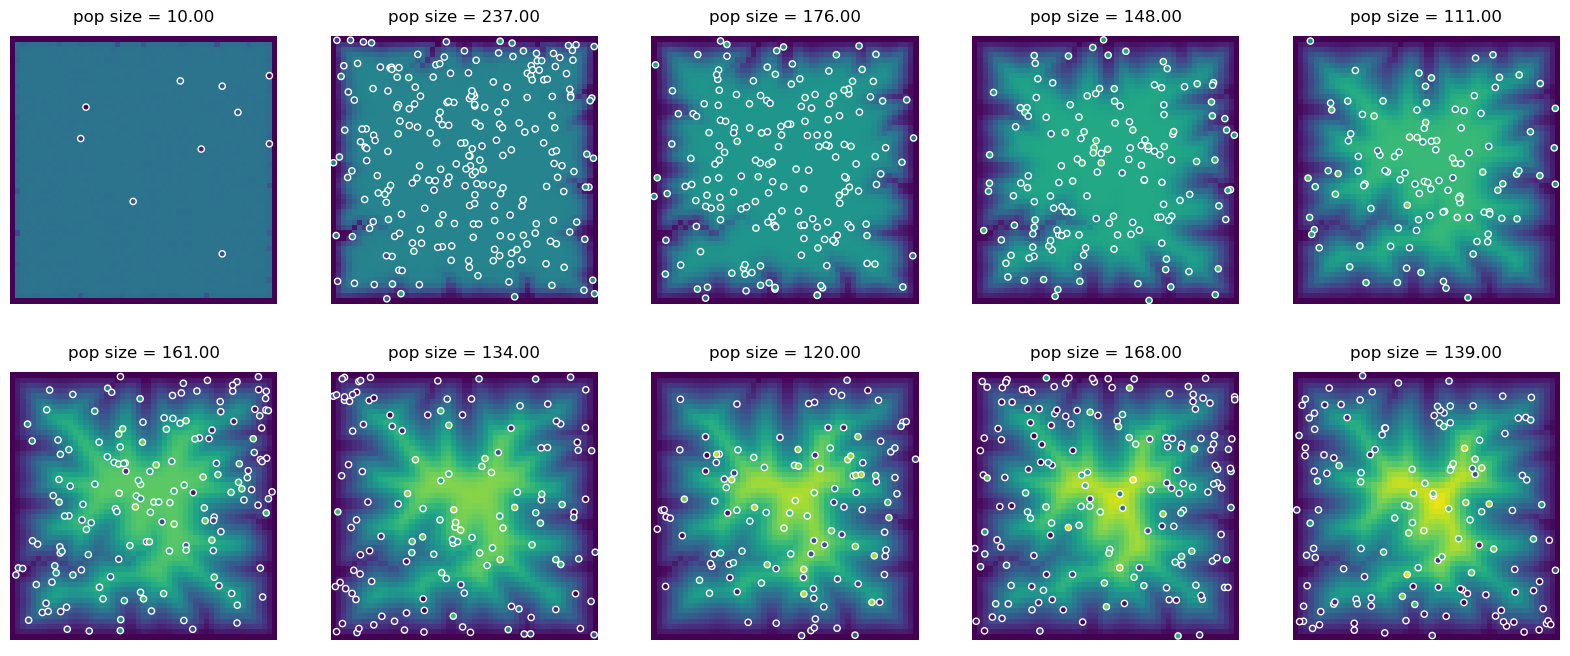

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axs = axs.ravel()
num = 0
for s in np.arange(0, nstep, int(nstep/10)):
    axs[num].pcolormesh(H[:, :, s], vmin=0, vmax=H.max())
    pop = population[population.gen==s]
    axs[num].scatter(pop.x+0.5, pop.y+0.5, c=pop.u, cmap='viridis', edgecolor='w', s=20, vmin=0, vmax=H.max())
    axs[num].axis('equal')
    axs[num].axis('off')
    axs[num].set_title('pop size = %.2f' %len(pop), fontsize =12)
    axs[num].set_xlim(0, nx)
    axs[num].set_ylim(0, ny)
    num+=1


In [26]:
population[population.gen==nstep-1].head(10)

,gen,x,y,u,a_id,n_neighbor,r_d,u_opt,w_i,n_offspring
30347,199.0,4.657645,34.063839,46.721371,30227.0,3.0,5.0,70.428442,0.535544,3.0
30348,199.0,11.769996,44.954422,56.780298,30227.0,3.0,5.0,91.935178,0.253299,1.0
30349,199.0,13.676263,43.723299,41.358506,30227.0,5.0,3.0,114.374229,0.002675,0.0
30350,199.0,5.949417,43.842024,69.965055,30227.0,3.0,5.0,93.442017,0.542044,3.0
30351,199.0,2.558421,46.996844,30.833024,30229.0,4.0,3.75,40.211431,0.906896,3.0
30352,199.0,6.644434,49.549556,23.483191,30229.0,4.0,3.75,17.401991,0.959743,4.0
30353,199.0,3.54011,49.76557,26.11846,30229.0,4.0,3.75,20.465913,0.965121,4.0
30354,199.0,19.857098,37.164161,18.197906,30232.0,5.0,3.0,179.660716,0.0,0.0
30355,199.0,19.0195,46.537933,49.436373,30236.0,8.0,1.875,36.296563,0.82544,2.0
30356,199.0,16.773633,37.230801,35.521511,30236.0,5.0,3.0,186.129148,0.0,0.0
